## Notebook to examine distribution of papers in a topic by their likehood of membership.

Try to answer the questions:
    'what is a good threshold/cutoff to exclude papers from a given topic, if any?'
    'Are there a large number of seemingly random, low-probability papers in a topic?'


In [1]:
import pandas as pd
import h5py
import os
import json
import math
import sys
import statistics as stat
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr, sem # standard error of mean
sys.path.append("../src")
from process import *

### Config

In [2]:
# defs of data to use

# Viz19, 10 Runs 125 topics, 'astro-only' high-impact journals, no SEDs
versions = ['19_2_125_rec1', '19_2_125_rec2','19_2_125_rec3','19_2_125_rec4','19_2_125_rec5',
            '19_2_125_rec6', '19_2_125_rec7','19_2_125_rec8','19_2_125_rec9','19_2_125_rec10'] 

citation_filename = '../data/astro_only_doc_citation_bibcode_cnts_2010.json'

# Document content type
#contentType = 'decadal'
contentType = 'whitepaper'

# Low cite threshold
low_cite_threshold = 10 # dont use papers with fewer cites than this

# min topic threshold to use
# IMPORTANT NOTE: we HAVE to have some way of discrimination of which citations to keep because otherwise
# we get the same average number of citations for every topic IF we have min_inference of 0 (e.g. ALL papers are relevant for 
# all topics, so its the same population, and hence values for avg citiations, for all topics).
# Best value is ~0.2
#
min_inferences = [0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] # threshold of paper inference to be included in citation count for a topic

# maximum inference threshold to use, discard everything above this
max_inference = 1.0

# use filtered? for 19_2_125 means no Grav Wave topic
use_filtered = True

# whether to use pearson or spearman coorelation
use_spearman = True

# minimum citations needed per topic
min_citations_needed = 3 # IF lower than this, we dont have enough data to estimate reasonable avg

# debug mode
chatty = False

In [3]:
# set filtering
filtered = "_filtered" if use_filtered else ""

### Code

In [4]:
def adj_cite_cnt(yr:int, cite_cnt:int)->int:
    #return eic_func(yr, cite_cnt)
    return sigmoid_func(yr, cite_cnt)

# from mmodel fitting astro journals we're using
cite_half_life = 10.7

# [p[0] * (1. - (0.5) ** (dx/p[1])) 
def eic_func(yr:int, cite_cnt:int)->int:
    ''' apply the 'exponential to constant' function with prior fitted values for this model '''
    #max_cite_est = cite_cnt / (1 - (0.5 ** ((2021 - yr)/cite_half_life)))
    max_cite_est = cite_cnt / (1 - (0.5 ** ((2011 - yr)/cite_half_life)))
    return int(max_cite_est)

# (p[0] / (1 + (p[1] * math.exp(p[2] * dx))))
# array([59.4822963 , 10.19423547, -0.39783075]),
def sigmoid_func1(yr:int, cite_cnt:int)->int:
    ''' apply the 'sigmoid/logistic growth' function with prior fitted values for this model '''
    max_cite_est = (cite_cnt + 72.5) * (1 + math.exp(-0.18 * (2010 - yr)))
    return int(max_cite_est)

# (p[0] / (1 + (p[1] * math.exp(p[2] * dx))))
# array([59.4822963 , 10.19423547, -0.39783075]),
def sigmoid_func(yr:int, cite_cnt:int)->int:
    ''' apply the 'sigmoid/logistic growth' function with prior fitted values for this model '''
    max_cite_est = cite_cnt * (10.194 * math.exp(-0.3978 * (2010 - yr)))
    return int(max_cite_est)

In [5]:
def load_topic_bibcode_h5py(viz_data_loc: os.PathLike)->pd.DataFrame:
    """
    Load object parameters from an hdf database.
    Args:
        viz_data_loc: path to hdf file
    """

    with h5py.File(viz_data_loc, "r") as f0:
        embedding = f0["embedding"][:]
        topic_coherences = f0["topic_coherences"][:]
        paper_ids = f0["paper_ids"][:]
        bibcodes = f0["bibcodes"][:]
        nasa_affiliation = f0["nasa_affiliation"][:]
        years = f0["years"][:]
        keyword_ids = f0["keyword_ids"][:]
        keywords = f0["keywords"][:]
        kwd_ts_values = f0["keyword_ts_values"][:]
        kwd_ts_cols = f0["keyword_cols"][:]

    #embedding_df = pd.DataFrame({"bibcodes": bibcodes, "embedding": embedding})
    embedding_df = pd.DataFrame(embedding)
    embedding_df['bibcodes'] = bibcodes
    embedding_df.index = paper_ids
        
    return embedding_df

# assemble dataset of papers by topic and counts
# We will use the inference value for each topics contribution to a paper as its fractional counts to contribute 
# to that topic (above min threshold value for inference). We co-add all paper fractional contributions to a topic
# then find the average number of citations for that topic
def get_citations(data:pd.DataFrame, bibcodes, min_inference:float, 
                  doc_topic_data:pd.DataFrame, version:str)->dict:
    
    topics = doc_topic_data['topic']
    topic_citations = { t:[] for t in topics }
    
    # step thru our paper data (~77k papers)
    for i, row in data.iterrows():
        
        # get paper properties we'll need
        bibcode = bibcodes[i].decode('utf-8')
        try:     
            est_cites = est_doc_citations[bibcode]
        except KeyError as kex:
            # this may happen because we culled low cite count paper
            # move to the next paper
            #print(f"failed to find cites for key:{kex}")
            continue

        # now iterate over topics to add in paper contribution
        for topic, inf_fraction in row.items():

            if topic in topic_citations.keys():
                if inf_fraction > min_inference and inf_fraction <= max_inference:
                    topic_citations[topic].append(est_cites) # the right way
                    #topic_citations[topic].append(est_cites*inf_fraction) # TEST!
                    #topic_citations[topic].append(inf_fraction) # ONLY Test, to see if correlated.. Ans: it is with TCS/RI because of how they are calculated. SO DONT USE.

    # safety check for too few citations
    for t in topic_citations.keys():
        if len(topic_citations[t]) < min_citations_needed:
            #print (f"Warning topic: {t} lacks enough citations for an average, ignoring")
            topic_citations[t] = []
            
    # get the mean
    bad_topics = []
    topic_avg_citations = {}
    for t in topic_citations:
        try:
            topic_avg_citations[t] = stat.mean(topic_citations[t])
        except Exception as ex:
            #print(f"Warning: cant calculate avg citations for topic {t}, setting to ignore")
            topic_avg_citations[t] = -1.
            bad_topics.append(t)

    #merge data for citation/topic with RI/topic
    cites = []
    for i,row in doc_topic_data.iterrows():
        topic = row['topic']
        cites.append(topic_avg_citations[topic])

    if chatty and len(bad_topics) > 0:
        print(f" * {version} dropped %s topics because of citation issues" % len(bad_topics))
    #print (f" LENGTH CITES: %s" % len(cites))
    return cites


In [6]:
def clean_doc_data (doc_topic_data:pd.DataFrame):
    
    orig_ri = list(doc_topic_data['ri'])
    orig_tcs = list(doc_topic_data['tcs']) # this is literature TCS
    orig_doc_tcs = list(doc_topic_data['doc_tcs']) # this is document TCS (decadal_report or whitepapers)
    orig_cagr = list(doc_topic_data['cagr'])
    orig_cites = list(doc_topic_data['avg_cites'])

    # Drop bad data (because of cites problem)
    tcs=[]
    ri=[]
    cagr=[]
    cites=[]
    doc_tcs=[]
    for t in range(0, len(list(doc_topic_data['topic']))):
        try:
            if orig_cites[t] == -1.:
                print (f" Dropping topic {t} because no good citation estimate")
            else:
                cites.append(orig_cites[t])
                ri.append(orig_ri[t]) 
                cagr.append(orig_cagr[t])
                tcs.append(orig_tcs[t])
                doc_tcs.append(orig_doc_tcs[t])

        except Exception as ex:
            print ("LEN of orig_x: %s" % len(orig_x))
            raise ex
    return cagr, cites, doc_tcs, tcs, ri
        

def process (versions:list, min_inference:float, contentType:str, chatty:bool=False, filtered:str="", spearman:bool=use_spearman):

    cagr_coeffs = []
    cagr_p_vals = []
    
    ri_coeffs = []
    ri_p_vals = []
    
    tcs_coeffs = []
    tcs_p_vals = []
    
    doc_tcs_coeffs = []
    doc_tcs_p_vals = []
    
    for version in versions:
        # load viz data with topic inferences
        viz_filename = f"../data/viz_data_{version}.hdf5"
        data = load_topic_bibcode_h5py(viz_filename)

        # pull out bibcodes
        bibcodes = data['bibcodes']
        del data['bibcodes']

        # load topic RI/CAGR/TCS data
        doc_topic_data = pd.read_csv(f'../results/{contentType}_topic_data_{version}{filtered}.csv') 

        # merge / add in citation data
        doc_topic_data['avg_cites'] = get_citations(data, bibcodes, min_inference, doc_topic_data, version)

        # something may go wrong in cites calculation, so drop negative citations (represents a failed calc)
        doc_topic_data = doc_topic_data[doc_topic_data['avg_cites'] >= 0.]

        # clean and split out data for analysis
        cagr, cites, doc_tcs, tcs, ri = clean_doc_data(doc_topic_data)
        
        # calculate correlations and plot - Cites vs TCS (literature)
        if spearman:
            coeff, p = spearmanr(cites, tcs)
        else:
            coeff, p = pearsonr(cites, tcs)
            
        if chatty:
            print (f"TCS:{version}{filtered} r:{coeff}, p:{p}")
        tcs_coeffs.append(coeff)
        tcs_p_vals.append(p)
        #plot_data (cites, tcs, ylabel="TCS", xlabel="MLCR", title=f"{version}\nr:%8.5f p:%12.10f" % (coeff, p), ax=None)
        
        # calculate correlations and plot - Cites vs TCS (document)
        if spearman:
            coeff, p = spearmanr(cites, doc_tcs)
        else:
            coeff, p = pearsonr(cites, doc_tcs)
            
        if chatty:
            print (f"DOC TCS:{version}{filtered} r:{coeff}, p:{p}")
        doc_tcs_coeffs.append(coeff)
        doc_tcs_p_vals.append(p)
        #plot_data (cites, doc_tcs, ylabel="TCS", xlabel="MLCR", title=f"{version}\nr:%8.5f p:%12.10f" % (coeff, p), ax=None)

        # calculate correlations and plot - Cites vs RI
        if spearman:
            coeff, p = spearmanr(cites, ri)
        else:
            coeff, p = pearsonr(cites, ri)
            
        if chatty:
            print (f"RI:{version} r:{coeff}, p:{p}")
           
        ri_coeffs.append(coeff)
        ri_p_vals.append(p)
        #plot_data (cites, ri, ylabel="RI", xlabel="MLCR", title=f"{version}\nr:%8.5f p:%12.10f" % (coeff, p), ax=None)

        if spearman:
            coeff, p = spearmanr(cites, cagr)
        else:
            coeff, p = pearsonr(cites, cagr)
            
        if chatty:
            print (f"CAGR:{version} r:{coeff}, p:{p}")
        cagr_coeffs.append(coeff)
        cagr_p_vals.append(p)
        
        if chatty:
            plot_data (cites, cagr, ylabel="CAGR", xlabel="MCLR", title=f"{version} ({min_inference} - {max_inference})\nr:%8.5f p:%12.10f" % (coeff, p), ax=None)

        # write out dataset
        doc_topic_data.to_csv(f'../results/ri_vs_citation_{contentType}_{version}_{min_inference}.csv')

    return cagr_coeffs, ri_coeffs, tcs_coeffs, doc_tcs_coeffs, tcs_p_vals, cagr_p_vals, ri_p_vals, doc_tcs_p_vals

### Do the work

In [7]:
# load raw citation info
doc_citations_raw = {}
with open (citation_filename, 'r') as f:
    doc_citations_raw = json.load(f)

In [8]:
# correct citation data based on 1 - exp-decay model (see notebook)
# to get a normalized population (as if all were equally out for same amount of time to be cited)
est_doc_citations = {}

for yr, docs in doc_citations_raw.items():
    cites = []
    adj_cites = []
    for bibcode, cite_cnt in docs.items():
        # use only papers with reasonable number of cites (low cite cnts are highly uncertain for estimation)
        if cite_cnt >= low_cite_threshold:
            est_doc_citations[bibcode] = adj_cite_cnt(int(yr),cite_cnt)
            cites.append(cite_cnt)
            adj_cites.append(est_doc_citations[bibcode])
        
    #print (f"Mean cites {yr}: flt:%s adj:%s" % (stat.mean(cites), stat.mean(adj_cites)))

#est_doc_citations[str(b'2000AJ....120.1579Y')]
#est_doc_citations

In [9]:
# do the analysis
print (f"%s%s (%s)\n" % (versions[0][:-5], filtered, contentType))
mean_cagrs = []
mean_ris = []
mean_doc_tcss = []
stderr_cagrs = []
stderr_ris = []
stderr_doc_tcss = []
for min_inference in min_inferences:
    
    print (f"min_inf:{min_inference}\n")
    #chatty = True if (min_inference == 0.2) else False
    cagr_coeffs, ri_coeffs, tcs_coeffs, doc_tcs_coeffs, tcs_p_vals, cagr_p_vals, ri_p_vals, doc_tcs_p_vals = process(versions, min_inference, 
                                                                                                                     contentType, chatty=chatty, 
                                                                                                                     filtered=filtered, spearman=use_spearman)

    print ("Mean Val ; StdDev; StdErr")
    
    mean_cagr = stat.mean(cagr_coeffs)
    mean_cagr_p = stat.mean(cagr_p_vals)
    mean_ri   = stat.mean(ri_coeffs)
    mean_ri_p = stat.mean(ri_p_vals)
    mean_tcs  = stat.mean(tcs_coeffs)
    mean_tcs_p = stat.mean(tcs_p_vals)
    mean_doc_tcs  = stat.mean(doc_tcs_coeffs)
    mean_doc_tcs_p  = stat.mean(doc_tcs_p_vals)
        
    stderr_cagr = sem(cagr_coeffs)
    stderr_cagr_p = sem(cagr_p_vals)
    
    stderr_ri   = sem(ri_coeffs)
    stderr_ri_p  = sem(ri_p_vals)
    
    stderr_tcs  = sem(tcs_coeffs)
    stderr_tcs_p  = sem(tcs_p_vals)
    
    stderr_doc_tcs  = sem(doc_tcs_coeffs)
    stderr_doc_tcs_p  = sem(doc_tcs_p_vals)
    
    print (f"DOC TCS: %8.5f, %8.5f" % (mean_doc_tcs, stderr_doc_tcs))
    print (f"TCS: %8.5f, %8.5f" % (mean_tcs, stderr_tcs))
    print (f"CAGR: %8.5f, %8.5f" % (mean_cagr, stderr_cagr))
    print (f"RI: %8.5f, %8.5f\n" % (mean_ri, stderr_ri))
  
    print (f"TCS Pval: %e, %e" % (mean_tcs_p, stderr_tcs_p))
    print (f"CAGR Pval: %e, %e" % (mean_cagr_p, stderr_cagr_p))
    print (f"RI Pval: %e, %e" % (mean_ri_p, stderr_ri_p))
    print (f"DOC TCS Pval: %e, %e\n" % (mean_doc_tcs_p, stderr_doc_tcs_p))
    
    mean_cagrs.append(mean_cagr)
    mean_doc_tcss.append(mean_doc_tcs)
    mean_ris.append(mean_ri)
    
    stderr_cagrs.append(stderr_cagr)
    stderr_doc_tcss.append(stderr_doc_tcs)
    stderr_ris.append(stderr_ri)


19_2_125_filtered (whitepaper)

min_inf:0.01

Mean Val ; StdDev; StdErr
DOC TCS:  0.25781,  0.01479
TCS:  0.00560,  0.02278
CAGR:  0.65434,  0.01216
RI:  0.37112,  0.01417

TCS Pval: 6.136895e-01, 9.936032e-02
CAGR Pval: 1.814279e-13, 1.795712e-13
RI Pval: 1.204531e-04, 6.168626e-05
DOC TCS Pval: 8.606520e-03, 2.796942e-03

min_inf:0.1

Mean Val ; StdDev; StdErr
DOC TCS:  0.26871,  0.01519
TCS:  0.01077,  0.02404
CAGR:  0.66957,  0.01050
RI:  0.38318,  0.01563

TCS Pval: 5.882759e-01, 1.031238e-01
CAGR Pval: 9.806169e-15, 9.696147e-15
RI Pval: 9.892108e-05, 5.576626e-05
DOC TCS Pval: 6.510490e-03, 2.501655e-03

min_inf:0.15

Mean Val ; StdDev; StdErr
DOC TCS:  0.29674,  0.01624
TCS:  0.04603,  0.02675
CAGR:  0.69167,  0.00920
RI:  0.42398,  0.01974

TCS Pval: 4.260220e-01, 8.563083e-02
CAGR Pval: 5.861123e-17, 4.968889e-17
RI Pval: 4.314377e-05, 3.264837e-05
DOC TCS Pval: 3.819354e-03, 2.514599e-03

min_inf:0.2

Mean Val ; StdDev; StdErr
DOC TCS:  0.31900,  0.01699
TCS:  0.08177,  0.02

### Plotting

In [10]:
def plot_data_errs (x, y, y_err, xlabel="", ylabel="", title="Title", ax=None, color='red'):
    if ax == None:
        fig, ax = plt.subplots()

    #plt.style.use('fivethirtyeight')

    ax.plot(x, y, marker='o', markerfacecolor=color, linestyle=' ')
    plt.errorbar(x, y, fmt='ko', yerr=y_err)

    ax.set_title(title)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    return ax

(0.1, 0.6)

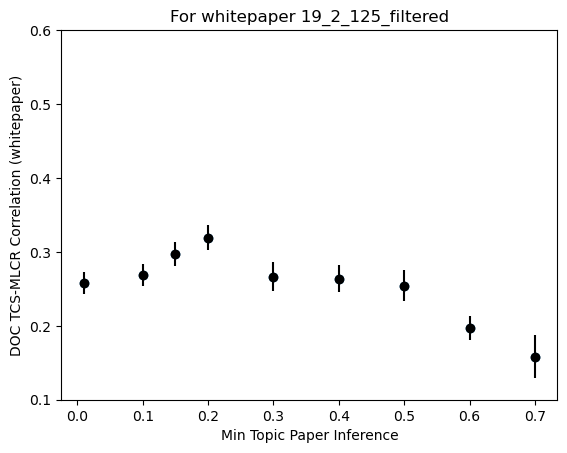

In [16]:
import matplotlib.pyplot as plt
ax = plot_data_errs (min_inferences, mean_doc_tcss, stderr_doc_tcss, 
                     ylabel=f"DOC TCS-MLCR Correlation ({contentType})", xlabel="Min Topic Paper Inference", 
                     title=f"For {contentType} %s%s" % (versions[0][:-5], filtered), ax=None)
ax.set_ylim([0.1, 0.6])

(0.35, 0.75)

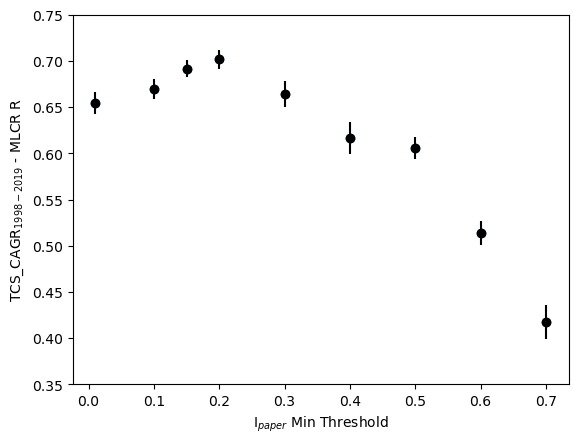

In [12]:
ax = plot_data_errs (min_inferences, mean_cagrs, stderr_cagrs, 
                     ylabel="TCS_CAGR$_{1998-2019}$ - MLCR R", xlabel="I$_{paper}$ Min Threshold", 
                     title="", #f"%s%s" % (versions[0][:-5], filtered), 
                     ax=None)
ax.set_ylim([0.35, 0.75])

### Save results

In [13]:
mlcr_data = pd.DataFrame({'mean_cagr': mean_cagrs, 'mean_ri': mean_ris, 'mean_doc_tcss':mean_doc_tcss, 
                          'stderr_cagr': stderr_cagrs, 'stderr_ri': stderr_ris, 'stderr_doc_tcs': stderr_doc_tcs, 
                          'min_inference': min_inferences})

vers = versions[0][:-5]
filename = f'../results/mlcr_min_inferences_{contentType}_{vers}{filtered}.csv'
print (f"wrote: {filename}")
mlcr_data.to_csv(filename, index=False)
    

wrote: ../results/mlcr_min_inferences_whitepaper_19_2_125_filtered.csv


In [14]:
min_inferences, mean_cagrs

([0.01, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
 [0.6543358140614721,
  0.6695696843843107,
  0.6916668842140563,
  0.7018445576608066,
  0.6643980136977466,
  0.61691238859295,
  0.6057592343707677,
  0.5135606983965441,
  0.41764218833784433])